In [1]:
#!/usr/bin/python3
import os
import sys
import argparse
import pdb
import h5py
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
import ast

import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical

sys.path.append("/home/mabon/MSB/tools")
import checking_tool
import loadData
import key_rank


def plot_figure(x, y, title_str, fig_save_name):
    plt.title(title_str)
    plt.xlabel('number of traces')
    plt.ylabel('rank')
    plt.grid(True)
    plt.plot(x, y)
    plt.savefig(fig_save_name)
    plt.show(block=False)
    plt.figure()


2024-01-18 14:46:39.319539: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
input1='/home/mabon/S1_K1_200k.npz'
model_dir='/home/mabon/testMSB/'
output='/home/mabon/testMSB/'
verbose=True
target_byte=2
leakage_model='MSB'
attack_window='1200_2200'
test_num=30000
preprocess=''
shifted=0
ranking_root=os.path.join(output, 'rank_dir')

In [3]:

def load_data():
    ''' load test data '''
    dpath = input1
    method = preprocess
    trace_num = test_num

    whole_pack = np.load(dpath)
    traces, text_in, key = loadData.load_data_base_test(whole_pack, attack_window, method, trace_num, shifted)
     
    ''' 
    #the following lines are for down sampleling
    n1=[]
    for i in range(0,int((np.shape(traces)[0]))):
        t1=[]
        for j in range(0,4000,4):
            t1.append(traces[i][j])
        n1.append(t1)
    traces=np.array(n1)
    '''


    inp_shape = (traces.shape[1], 1)
    labels = loadData.get_labels(text_in, key[target_byte], target_byte, leakage_model)

    clsNum = 9 if 'HW' == leakage_model else (256 if 'ID' == leakage_model else 2)
    labels = to_categorical(labels, clsNum)
    return traces, labels, text_in, key, inp_shape

In [4]:
# Check a saved model against one of the testing databases Attack traces
def main():
    # checking model file existence
    cnn_model_path = os.path.join(model_dir, 'model', 'best_model.h5')
    ranking_root = os.path.join(output, 'rank_dir')
    os.makedirs(ranking_root, exist_ok=True)

    # Load model
    model = checking_tool.load_best_model(cnn_model_path)
    model.summary()

    # Load profiling and attack data and metadata from the ASCAD database
    X_attack, Y_attack, plaintext, key, inp_shape = load_data()

    # Get the input layer shape and Sanity check
    input_layer_shape = model.get_layer(index=0).input_shape
    if isinstance(input_layer_shape, list):
        input_layer_shape = input_layer_shape[0]
    Reshaped_X_attack = loadData.sanity_check(input_layer_shape, X_attack)

    # run the accuracy test
    score, acc = model.evaluate(Reshaped_X_attack, Y_attack, verbose=verbose)
    print('[LOG] -- test acc is: {:f}'.format(acc))

    preds = model.predict(X_attack)
    return preds,key,plaintext

In [5]:
preds,key,plaintext=main()

loading pre-trained model...


2024-01-18 14:46:42.163829: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2024-01-18 14:46:42.313754: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2024-01-18 14:46:42.380701: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-01-18 14:46:42.380858: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:02:00.0 name: NVIDIA TITAN RTX computeCapability: 7.5
coreClock: 1.77GHz coreCount: 72 deviceMemorySize: 23.64GiB deviceMemoryBandwidth: 625.94GiB/s
2024-01-18 14:46:42.380878: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2024-01-18 14:46:42.418798: I tensorflow/stream_executor/platform/default/d

Model: "cnn_best"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1000, 1)]         0         
_________________________________________________________________
block1_conv1 (Conv1D)        (None, 500, 64)           768       
_________________________________________________________________
block1_pool (AveragePooling1 (None, 250, 64)           0         
_________________________________________________________________
block2_conv1 (Conv1D)        (None, 250, 128)          90240     
_________________________________________________________________
block2_pool (AveragePooling1 (None, 125, 128)          0         
_________________________________________________________________
block3_conv1 (Conv1D)        (None, 125, 256)          360704    
_________________________________________________________________
block3_pool (AveragePooling1 (None, 62, 256)           0  

2024-01-18 14:46:49.812420: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2024-01-18 14:46:49.812808: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2799925000 Hz
2024-01-18 14:46:49.984151: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2024-01-18 14:46:50.187158: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
2024-01-18 14:46:51.182669: W tensorflow/stream_executor/gpu/asm_compiler.cc:63] Running ptxas --version returned 256
2024-01-18 14:46:51.268215: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 256, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


938/938 [==============================] - 11s 7ms/step - loss: 0.6708 - accuracy: 0.5855
[LOG] -- test acc is: 0.585467


In [6]:
MSB_byte=[0,0,0,0,1,0,0,1,0,0,0,0,1,1,1,0,1,1,1,0,1,0,0,
 1,1,1,1,1,1,1,0,1,1,1,1,0,0,0,1,1,0,1,1,1,0,1,
 0,0,0,1,0,1,0,1,0,1,0,0,1,1,1,0,1,0,0,1,0,0,0,
 0,0,1,0,0,1,1,0,1,0,1,0,1,0,1,0,1,1,0,0,1,1,0,
 0,0,0,1,1,1,1,1,0,0,0,1,0,1,0,0,0,0,1,1,0,1,0,
 1,1,1,0,1,1,1,1,0,0,1,1,1,1,0,0,1,0,1,0,0,1,1,
 0,0,0,0,0,0,0,1,0,1,0,0,1,1,0,1,1,0,1,0,0,1,1,
 0,0,0,0,0,0,0,1,1,1,0,1,1,1,0,1,1,0,0,1,1,0,1,
 0,0,1,1,0,0,1,0,1,0,0,0,0,1,1,1,1,1,0,0,0,1,1,
 1,0,0,1,0,0,0,1,0,0,0,0,1,1,1,0,1,1,1,1,0,0,1,
 1,1,1,0,1,1,1,0,0,1,1,1,1,0,1,1,0,0,0,1,0,0,1,
 0,1,0]
HW_byte = [0, 1, 1, 2, 1, 2, 2, 3, 1, 2, 2, 3, 2, 3, 3, 4, 1, 2, 2, 3, 2, 3, 3, 4, 2, 3, 3, 4, 3, 4, 4, 5, 1, 2, 2,
           3, 2, 3, 3, 4, 2, 3, 3, 4, 3, 4, 4, 5, 2, 3, 3, 4, 3, 4, 4, 5, 3, 4, 4, 5, 4, 5, 5, 6, 1, 2, 2, 3, 2, 3,
           3, 4, 2, 3, 3, 4, 3, 4, 4, 5, 2, 3, 3, 4, 3, 4, 4, 5, 3, 4, 4, 5, 4, 5, 5, 6, 2, 3, 3, 4, 3, 4, 4, 5, 3,
           4, 4, 5, 4, 5, 5, 6, 3, 4, 4, 5, 4, 5, 5, 6, 4, 5, 5, 6, 5, 6, 6, 7, 1, 2, 2, 3, 2, 3, 3, 4, 2, 3, 3, 4,
           3, 4, 4, 5, 2, 3, 3, 4, 3, 4, 4, 5, 3, 4, 4, 5, 4, 5, 5, 6, 2, 3, 3, 4, 3, 4, 4, 5, 3, 4, 4, 5, 4, 5, 5,
           6, 3, 4, 4, 5, 4, 5, 5, 6, 4, 5, 5, 6, 5, 6, 6, 7, 2, 3, 3, 4, 3, 4, 4, 5, 3, 4, 4, 5, 4, 5, 5, 6, 3, 4,
           4, 5, 4, 5, 5, 6, 4, 5, 5, 6, 5, 6, 6, 7, 3, 4, 4, 5, 4, 5, 5, 6, 4, 5, 5, 6, 5, 6, 6, 7, 4, 5, 5, 6, 5,
           6, 6, 7, 5, 6, 6, 7, 6, 7, 7, 8]


In [7]:

Sbox = [99, 124, 119, 123, 242, 107, 111, 197, 48, 1, 103, 43, 254, 215, 171, 118, 202, 130, 201, 125, 250, 89, 71,
        240, 173, 212, 162, 175, 156, 164, 114, 192, 183, 253, 147, 38, 54, 63, 247, 204, 52, 165, 229, 241, 113, 216,
        49, 21, 4, 199, 35, 195, 24, 150, 5, 154, 7, 18, 128, 226, 235, 39, 178, 117, 9, 131, 44, 26, 27, 110, 90, 160,
        82, 59, 214, 179, 41, 227, 47, 132, 83, 209, 0, 237, 32, 252, 177, 91, 106, 203, 190, 57, 74, 76, 88, 207, 208,
        239, 170, 251, 67, 77, 51, 133, 69, 249, 2, 127, 80, 60, 159, 168, 81, 163, 64, 143, 146, 157, 56, 245, 188,
        182, 218, 33, 16, 255, 243, 210, 205, 12, 19, 236, 95, 151, 68, 23, 196, 167, 126, 61, 100, 93, 25, 115, 96,
        129, 79, 220, 34, 42, 144, 136, 70, 238, 184, 20, 222, 94, 11, 219, 224, 50, 58, 10, 73, 6, 36, 92, 194, 211,
        172, 98, 145, 149, 228, 121, 231, 200, 55, 109, 141, 213, 78, 169, 108, 86, 244, 234, 101, 122, 174, 8, 186,
        120, 37, 46, 28, 166, 180, 198, 232, 221, 116, 31, 75, 189, 139, 138, 112, 62, 181, 102, 72, 3, 246, 14, 97,
        53, 87, 185, 134, 193, 29, 158, 225, 248, 152, 17, 105, 217, 142, 148, 155, 30, 135, 233, 206, 85, 40, 223, 140,
        161, 137, 13, 191, 230, 66, 104, 65, 153, 45, 15, 176, 84, 187, 22]


In [8]:
max_trace_num = min(10000, preds.shape[0])

In [9]:
import random
num_averaged=2
trace_num_max=30000
time=1

In [10]:
guessing_entropy = np.zeros((num_averaged, trace_num_max))
success_flag = np.zeros((num_averaged, trace_num_max))
real_key = key[target_byte]
plaintext = plaintext[:, target_byte]

In [11]:
random_index = list(range(plaintext.shape[0]))
random.shuffle(random_index)
random_index = random_index[0:trace_num_max]
score_mat = np.zeros((trace_num_max, 256))

In [12]:
for key_guess in range(0, 256):
    for i in range(0, trace_num_max):
        initialState = int(plaintext[random_index[i]]) ^ key_guess
        sout = Sbox[initialState]
        if leakage_model == 'ID':
            label = sout
        elif leakage_model == 'HW':
            label = HW_byte[sout]
        elif leakage_model == 'MSB':
            label = MSB_byte[sout]
        score_mat[i, key_guess] = preds[random_index[i], label]

In [13]:
score_mat = np.log(score_mat + 1e-40)

In [14]:
guessing_entropy = np.zeros((num_averaged, trace_num_max))
success_flag = np.zeros((num_averaged, trace_num_max))


In [15]:
for i in range(0, trace_num_max):
    log_likelihood = np.sum(score_mat[0:i+1, :], axis=0)
    ranked = np.argsort(log_likelihood)[::-1]
    guessing_entropy[time, i] = list(ranked).index(real_key)
    if list(ranked).index(real_key) == 0:
        success_flag[time, i] = 1

In [16]:
guessing_entropy = np.mean(guessing_entropy, axis=0)

In [71]:
ranked

array([202, 243, 116, 192,  88, 179, 247, 225,  31,  43, 104,  92, 100,
       186, 152, 204, 244, 203, 142, 130, 176, 158,  79,  10,  25,  50,
       110, 248, 102, 154, 207, 201, 226, 165,   9, 169,  87, 224, 205,
        72, 163, 155,  56, 111,  95, 242, 255, 236,  12, 126,  39, 112,
       101,  15, 172, 249, 209, 223,  33, 106,  93, 251,  57, 117, 145,
       188,  32,  49,  78,  96,  11,  19, 200, 170, 151,  68,  86,  13,
       143,  81,  21,  94, 206, 230,  26, 220, 232, 217, 148,  91,  89,
        77,  76, 216, 187, 160, 180, 159,  97,  85, 162,  55,  29, 253,
       136, 254, 229,  40,  80,   7,  28,  54, 119,  75, 122,  30, 218,
         3,  52, 196, 246,  34, 239,  48, 108, 164, 219,  36, 197,   5,
       114, 156,  64, 178,  53, 231, 177,  62, 141,  18, 137, 199, 191,
       182,  98, 233, 195, 222, 241, 190, 105,  38, 115, 208, 124, 153,
       228, 140, 234, 181, 134,  90, 127, 245, 103, 166, 183, 184,  70,
        73, 237,  63, 107, 144, 167,  44,  47,  71,  99,  58,  6

In [ ]:
def ranking_curve(preds, key, plaintext, target_byte, rank_root, leakage_model='MSB', trace_num_max=500):

    # GE/SR is averaged over 100 attacks 
    num_averaged = 1
    guessing_entropy = np.zeros((num_averaged, trace_num_max))
    success_flag = np.zeros((num_averaged, trace_num_max))

    real_key = key[target_byte]
    plaintext = plaintext[:, target_byte]

#     # attack multiples times for average
    for time in range(num_averaged):
        # select the attack traces randomly
        random_index = list(range(plaintext.shape[0]))

#         #         ## customized by HL
#         #         print(f"random_index shape {len(random_index)}, max value {max(random_index)}, min value {min(random_index)}")

        random.shuffle(random_index)
        random_index = random_index[0:trace_num_max]

        #         ## customized by HL
        #         print(f"random_index shape after slicing {len(random_index)}, max value {max(random_index)}, min value {min(random_index)}")

        # initialize score matrix
        score_mat = np.zeros((trace_num_max, 256))
        for key_guess in range(0, 256):
            for i in range(0, trace_num_max):
                initialState = int(plaintext[random_index[i]]) ^ key_guess
                sout = Sbox[initialState]
                if leakage_model == 'ID':
                    label = sout
                elif leakage_model == 'HW':
                    label = HW_byte[sout]
                elif leakage_model == 'MSB':
                    label = MSB_byte[sout]
                try:
                    score_mat[i, key_guess] = preds[random_index[i], label]
                except Exception as e:
                    pdb.set_trace()
                    print(e.message)
        score_mat = np.log(score_mat + 1e-40)

        #         ## customized by HL
        #         print(f"score_mat {score_mat}")

        for i in range(0, trace_num_max):
            log_likelihood = np.sum(score_mat[0:i+1, :], axis=0)
            ranked = np.argsort(log_likelihood)[::-1]
            guessing_entropy[time, i] = list(ranked).index(real_key)
            if list(ranked).index(real_key) == 0:
                success_flag[time, i] = 1

    guessing_entropy = np.mean(guessing_entropy, axis=0)


In [22]:
guessing_entropy=ranking_curve(preds, key, plaintext, target_byte, ranking_root, leakage_model, max_trace_num)

NameError: name 'ranking_curve' is not defined

In [ ]:
#     preds = model.predict(X_attack)
    max_trace_num = min(10000, preds.shape[0])
    key_rank.ranking_curve(preds, key, plaintext, target_byte, ranking_root, leakage_model, max_trace_num)
    print('[LOG] ---- all doneQ!')

    whole_pack = np.load(os.path.join(ranking_root,'ranking_raw_data.npz'))
    try:    s
        x, y = whole_pack['x'], whole_pack['y']
    except:
        y = whole_pack['y']
    for i in range(len(x)):
        if(y[i]<0.6):
            print("KRC............",i)
            break    

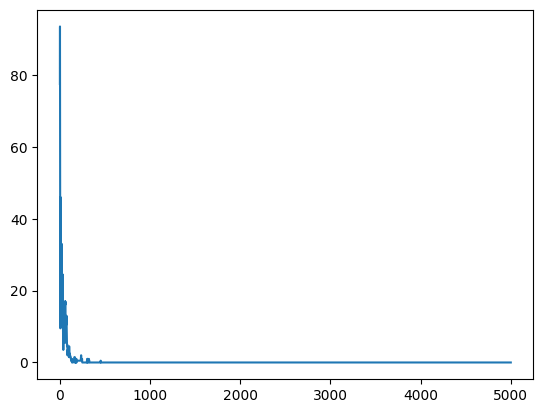

In [19]:
plt.plot(guessing_entropy[0:5000])


In [55]:
for i in range(len(guessing_entropy)):
    if guessing_entropy[i]<30:
        print(i)

432
443
444
487
488
489
490
